In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to the folder in your Google Drive
folder_path = '/content/drive/My Drive/tomato_combined_balanced_dataset'

Mounted at /content/drive


In [ ]:
# Verify the current working directory
print(f"Current working directory: {os.getcwd()}")

# List the contents of the folder
print("Contents of the folder:")
for item in os.listdir(folder_path):
    print(item)

Current working directory: /content
Contents of the folder:
Yellow_Leaf_Curl_Virus
Target_Spot
Septoria_leaf_spot
Mosaic_virus
Leaf_Mold
Healthy
Late_blight
Early_blight
Bacterial_spot


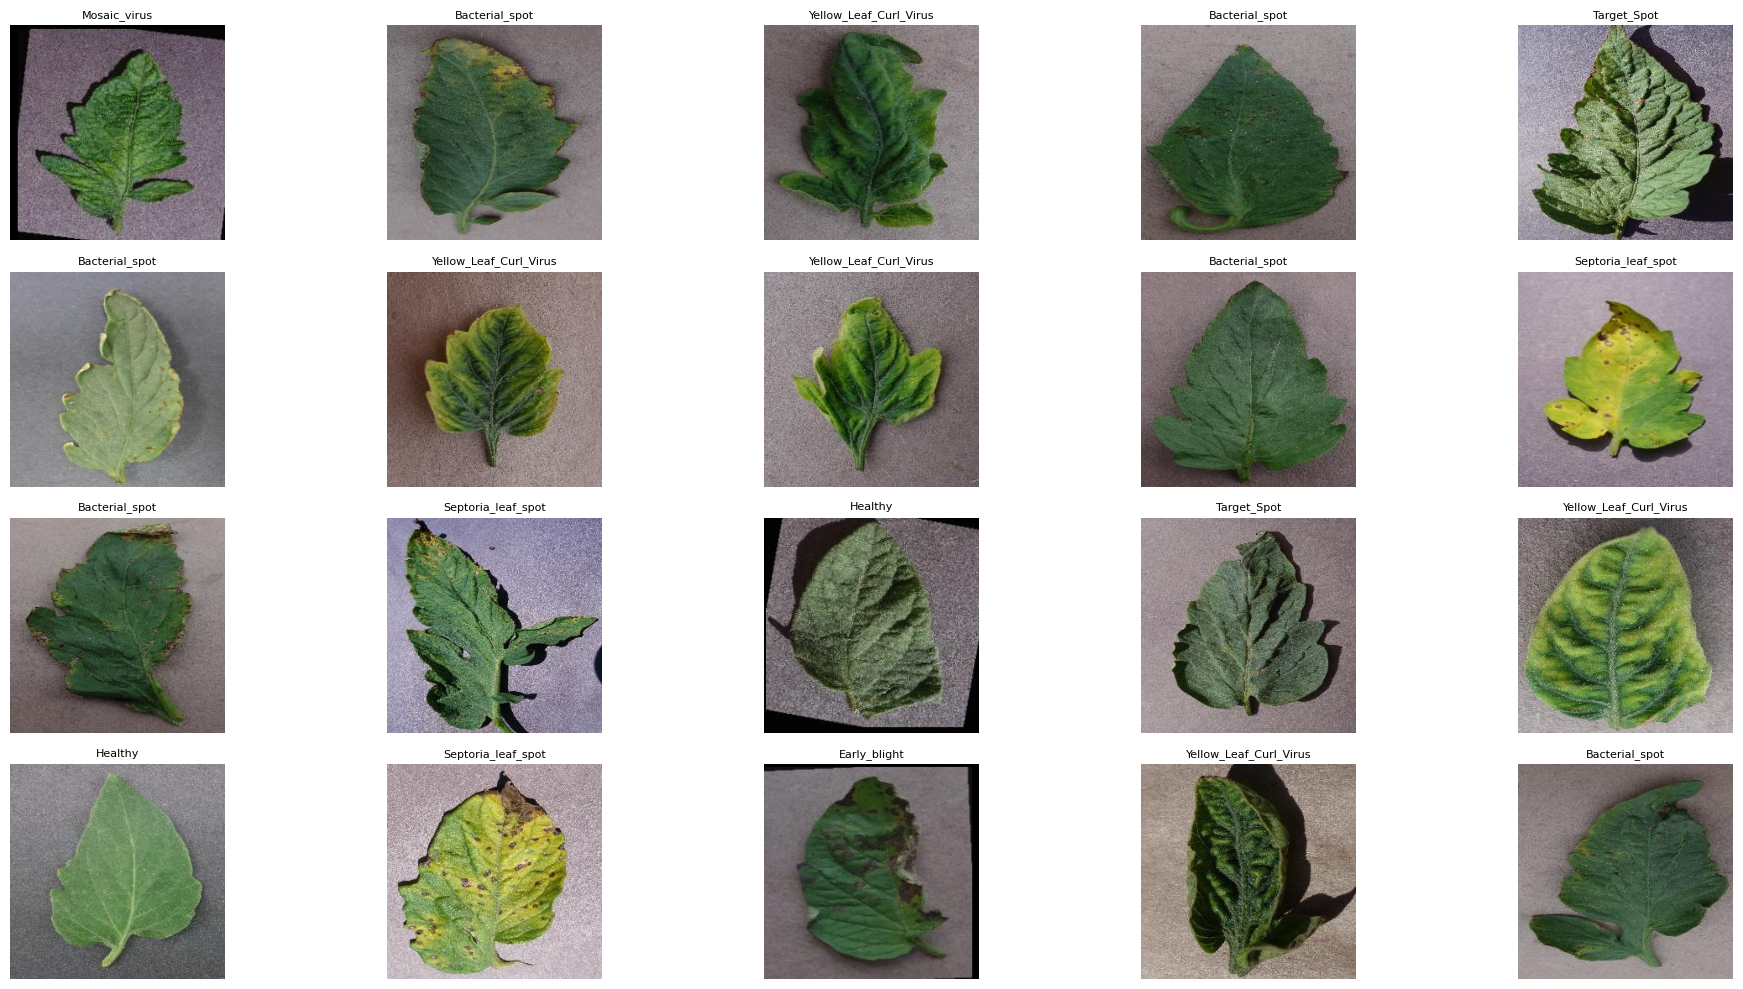

In [ ]:
import random
import matplotlib.image as mpimg

data_dir = folder_path

# Collect all image paths with their label (folder name)
image_paths = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                image_paths.append((os.path.join(class_path, fname), class_name))

# Randomly select 20 images
selected_images = random.sample(image_paths, 20)

# Plot the images
plt.figure(figsize=(20, 10))
for idx, (img_path, label) in enumerate(selected_images):
    img = mpimg.imread(img_path)
    plt.subplot(4, 5, idx + 1)
    plt.imshow(img)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!cp -r "/content/drive/My Drive/tomato_combined_balanced_dataset" /content/


In [4]:
print(tf.config.list_logical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [5]:
batch_size = 64
img_height = 192
img_width = 192
seed = 123
data_dir = "/content/tomato_combined_balanced_dataset"

In [6]:
import os
import json
import pickle

In [15]:
checkpoint_dir = '/content/drive/My Drive/tomato_model_checkpoints'  # Where to save checkpoints

# Create checkpoint directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# ============== CHECK FOR PREVIOUS TRAINING ==============
checkpoint_info_path = os.path.join(checkpoint_dir, 'training_info.json')
history_path = os.path.join(checkpoint_dir, 'training_history.pkl')
initial_epoch = 0
previous_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

if os.path.exists(checkpoint_info_path):
    with open(checkpoint_info_path, 'r') as f:
        info = json.load(f)
        initial_epoch = info['last_epoch']
        print(f"🔄 FOUND PREVIOUS TRAINING - Resuming from epoch {initial_epoch}")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            previous_history = pickle.load(f)
            print(f"📊 Last training metrics:")
            print(f"   Train Accuracy: {previous_history['accuracy'][-1]:.4f}")
            print(f"   Val Accuracy: {previous_history['val_accuracy'][-1]:.4f}")
else:
    print("🆕 Starting fresh training")


🔄 FOUND PREVIOUS TRAINING - Resuming from epoch 55
📊 Last training metrics:
   Train Accuracy: 0.8159
   Val Accuracy: 0.8089


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18030 files belonging to 9 classes.
Using 14424 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 18030 files belonging to 9 classes.
Using 3606 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Yellow_Leaf_Curl_Virus']

In [9]:
num_classes = len(train_ds.class_names)
print("Classes:", train_ds.class_names)

Classes: ['Bacterial_spot', 'Early_blight', 'Healthy', 'Late_blight', 'Leaf_Mold', 'Mosaic_virus', 'Septoria_leaf_spot', 'Target_Spot', 'Yellow_Leaf_Curl_Virus']


In [ ]:
for image_batch, labels in train_ds.take(1):
		print(image_batch.shape)
		print(labels.shape)

(64, 192, 192, 3)
(64,)


In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

In [ ]:
base_model = tf.keras.applications.ConvNeXtTiny(
    include_top=False,
    weights="imagenet",
    input_shape=(img_width, img_height, 3),
    pooling="avg"
)

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False   # freeze for transfer learning

inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.convnext.preprocess_input(x)  # preprocess for ConvNeXt
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
model_path = os.path.join(checkpoint_dir, f'model_epoch_{initial_epoch}.keras')
if initial_epoch > 0 and os.path.exists(model_path):
    print(f"📂 Loading existing model from epoch {initial_epoch}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")
else:
    print("🏗️ Building new model")
    base_model = tf.keras.applications.ConvNeXtTiny(
        include_top=False,
        weights="imagenet",
        input_shape=(img_width, img_height, 3),
        pooling="avg"
    )
    base_model.trainable = False   # freeze for transfer learning

    inputs = tf.keras.Input(shape=(img_width, img_height, 3))
    x = data_augmentation(inputs)
    x = tf.keras.applications.convnext.preprocess_input(x)  # preprocess for ConvNeXt
    x = base_model(x, training=False)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )

🏗️ Building new model


In [12]:
class SaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_dir, previous_history):
        self.checkpoint_dir = checkpoint_dir
        self.history = previous_history

    def on_epoch_end(self, epoch, logs=None):
        actual_epoch = epoch

        # Update history
        for key in logs:
            if key in self.history:
                self.history[key].append(logs[key])

        # Save model
        model_path = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch}.keras')
        self.model.save(model_path)

        # Save just weights too (smaller file)
        weights_path = os.path.join(self.checkpoint_dir, f'weights_epoch_{actual_epoch}.weights.h5')

        self.model.save_weights(weights_path)
        info = {
            'last_epoch': actual_epoch,
            'val_accuracy': float(logs['val_accuracy']),
            'train_accuracy': float(logs['accuracy'])
        }
        with open(os.path.join(self.checkpoint_dir, 'training_info.json'), 'w') as f:
            json.dump(info, f)

        # Save history
        with open(os.path.join(self.checkpoint_dir, 'training_history.pkl'), 'wb') as f:
            pickle.dump(self.history, f)

        if actual_epoch > 3:
            old_model = os.path.join(self.checkpoint_dir, f'model_epoch_{actual_epoch-3}.keras')
            old_weights = os.path.join(self.checkpoint_dir, f'weights_epoch_{actual_epoch-3}.weights.h5')
            if os.path.exists(old_model):
                os.remove(old_model)
            if os.path.exists(old_weights):
                os.remove(old_weights)

        print(f"\n💾 Checkpoint saved: Epoch {actual_epoch} - "
              f"Train Acc: {logs['accuracy']:.4f}, Val Acc: {logs['val_accuracy']:.4f}")


In [ ]:
# First training phase (epochs 1-25 or resume from checkpoint)
if initial_epoch < 20:
    print(f"\n🚀 Training Phase 1: Epoch {initial_epoch + 1} to 25")
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=initial_epoch,
        epochs=25,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

    initial_epoch = 25
    print("✅ Phase 1 complete!")

print("\n🎉 Training Complete!")
print(f"📁 Models saved in: {checkpoint_dir}")


🚀 Training Phase 1: Epoch 1 to 25
Epoch 1/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.3572 - loss: 1.8510
💾 Checkpoint saved: Epoch 1 - Train Acc: 0.3946, Val Acc: 0.5227
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 647ms/step - accuracy: 0.3573 - loss: 1.8505 - val_accuracy: 0.5227 - val_loss: 1.4370
Epoch 2/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.4840 - loss: 1.4930
💾 Checkpoint saved: Epoch 2 - Train Acc: 0.5013, Val Acc: 0.5804
226/226 ━━━━━━━━━━━━━━━━━━━━ 213s 698ms/step - accuracy: 0.4841 - loss: 1.4928 - val_accuracy: 0.5804 - val_loss: 1.2660
Epoch 3/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.5587 - loss: 1.2971
💾 Checkpoint saved: Epoch 3 - Train Acc: 0.5704, Val Acc: 0.6118
226/226 ━━━━━━━━━━━━━━━━━━━━ 158s 698ms/step - accuracy: 0.5587 - loss: 1.2969 - val_accuracy: 0.6118 - val_loss: 1.1533
Epoch 4/25
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.6037 - loss: 1.1612
💾 Checkpoint saved: Epoch 4 - Train Acc: 0.6075, Val Ac

In [ ]:
if initial_epoch > 0 and os.path.exists(model_path):
    print(f"📂 Loading existing model from epoch {initial_epoch}")
    model = tf.keras.models.load_model(model_path)
    print("✅ Model loaded successfully!")

In [ ]:
history_continued = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=initial_epoch,
        epochs=30,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

Epoch 26/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8076 - loss: 0.5860
💾 Checkpoint saved: Epoch 51 - Train Acc: 0.8071, Val Acc: 0.8017
226/226 ━━━━━━━━━━━━━━━━━━━━ 160s 708ms/step - accuracy: 0.8076 - loss: 0.5860 - val_accuracy: 0.8017 - val_loss: 0.6386
Epoch 27/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8106 - loss: 0.5773
💾 Checkpoint saved: Epoch 52 - Train Acc: 0.8082, Val Acc: 0.8050
226/226 ━━━━━━━━━━━━━━━━━━━━ 158s 702ms/step - accuracy: 0.8106 - loss: 0.5773 - val_accuracy: 0.8050 - val_loss: 0.6314
Epoch 28/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8132 - loss: 0.5642
💾 Checkpoint saved: Epoch 53 - Train Acc: 0.8146, Val Acc: 0.8039
226/226 ━━━━━━━━━━━━━━━━━━━━ 209s 733ms/step - accuracy: 0.8132 - loss: 0.5642 - val_accuracy: 0.8039 - val_loss: 0.6293
Epoch 29/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.8170 - loss: 0.5612
💾 Checkpoint saved: Epoch 54 - Train Acc: 0.8149, Val Acc: 0.8062
226/226 ━━━━━━━━━

In [13]:

import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/drive/My Drive/tomato_model_checkpoints/model_epoch_55.keras"
)


In [16]:
history_continued_1 = model.fit(
        train_ds,
        validation_data=test_ds,
        initial_epoch=30,
        epochs=60,
        callbacks=[SaveCallback(checkpoint_dir, previous_history)]
    )

Epoch 31/60
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.8176 - loss: 0.5514
💾 Checkpoint saved: Epoch 30 - Train Acc: 0.8175, Val Acc: 0.8103
226/226 ━━━━━━━━━━━━━━━━━━━━ 184s 740ms/step - accuracy: 0.8176 - loss: 0.5514 - val_accuracy: 0.8103 - val_loss: 0.6083
Epoch 32/60
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8221 - loss: 0.5416
💾 Checkpoint saved: Epoch 31 - Train Acc: 0.8223, Val Acc: 0.8123
226/226 ━━━━━━━━━━━━━━━━━━━━ 156s 691ms/step - accuracy: 0.8221 - loss: 0.5416 - val_accuracy: 0.8123 - val_loss: 0.6071
Epoch 33/60
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.8245 - loss: 0.5437
💾 Checkpoint saved: Epoch 32 - Train Acc: 0.8229, Val Acc: 0.8142
226/226 ━━━━━━━━━━━━━━━━━━━━ 211s 731ms/step - accuracy: 0.8245 - loss: 0.5437 - val_accuracy: 0.8142 - val_loss: 0.6012
Epoch 34/60
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8233 - loss: 0.5370
💾 Checkpoint saved: Epoch 33 - Train Acc: 0.8216, Val Acc: 0.8128
226/226 ━━━━━━━━━

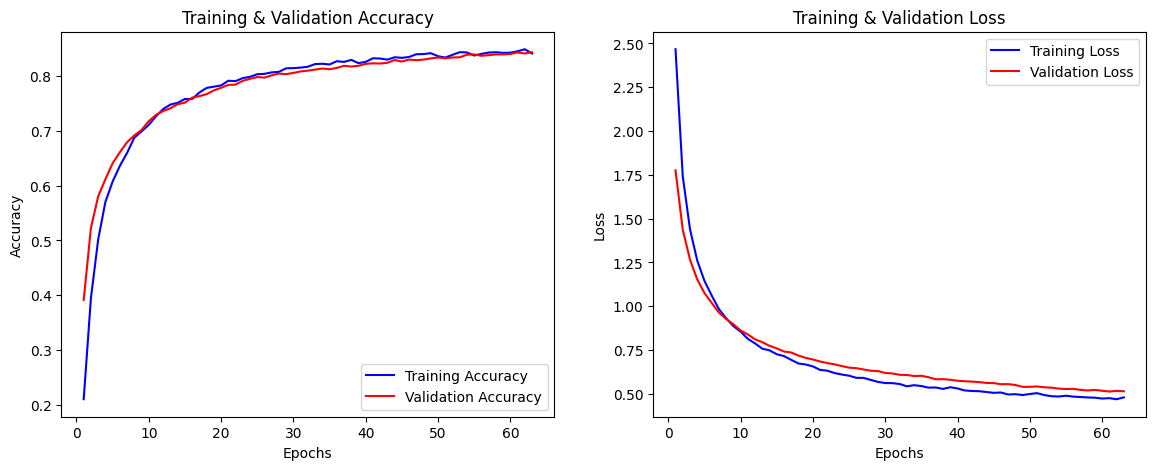

In [3]:
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import os

history_path = "/content/drive/My Drive/tomato_model_checkpoints/training_history.pkl"


# ---- Load history ----
with open(history_path, "rb") as f:
    history = pickle.load(f)

# ---- Plot training vs validation accuracy and loss ----
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b-", label="Training Accuracy")
plt.plot(epochs, val_acc, "r-", label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r-", label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
